# Case 3 - Method Testing

Here I provide a list of (possibly) usable functions for the third test case problem (portfolio allocation).

In [36]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import pandas as pd

import os
assert os.path.exists("Acutal Testing Data.csv")

# can't use sklearn rip, gotta self implement
def pca(vec, comp=-1):
    """Perform PCA, output components + explained variance %"""
    c_vec = vec - np.mean(vec, axis=0)
    cov = np.cov(c_vec) / vec.shape[0]
    v, w = np.linalg.eig(cov)
    idx = v.argsort()[::-1] # Sort descending and get sorted indices
    v = v[idx]
    w = w[:,idx]
    return w[:, :comp], np.sum(np.square(v[:comp]))/np.sum(np.square(v))

In [2]:
# (Hyper)parameter dict structure
# this is used to streamline training / searching as well as make function defining more simple

example_params = {
    "lookback" : 3,
    "EMA_eps" : 0.01,
    "alpha_w" : [0.3, 0.7], # weights for self preds and "pro" preds
    "pca_count" : 1,
    "var_penalty" : 1,
    "var_cap" : 0.01,
}

### Function List

Functions will need to pass a parameter dict of the above form.

In [82]:
# Obtain returns and forecasted returns from I/O
def obtainReturns():
    """
    Return array structures, all_rets, and all_pred_rets
    """
    atdf = pd.read_csv("Acutal Testing Data.csv")
    ptdf1 = pd.read_csv("Predicted Testing Data Analyst 1.csv")
    ptdf2 = pd.read_csv("Predicted Testing Data Analyst 1.csv")
    ptdf3 = pd.read_csv("Predicted Testing Data Analyst 1.csv")
    idx = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
    price = np.array([list(atdf[idx[i]]) for i in range(len(idx))])
    price1 = np.array([list(ptdf1[idx[i]]) for i in range(len(idx))])
    price2 = np.array([list(ptdf2[idx[i]]) for i in range(len(idx))])
    price3 = np.array([list(ptdf3[idx[i]]) for i in range(len(idx))])
    n = atdf.shape[0]
    all_rets = (price[:, 1:] - price[:, :-1]) / price[:, :-1]
    all_pred_rets1 = (price1[:, 1:] - price1[:, :-1]) / price1[:, :-1]
    all_pred_rets2 = (price2[:, 1:] - price2[:, :-1]) / price2[:, :-1]
    all_pred_rets3 = (price3[:, 1:] - price3[:, :-1]) / price3[:, :-1]
    return all_rets, all_pred_rets1, all_pred_rets2, all_pred_rets3

# Generate alphas from features and hyperparameters
# Considered methods include EMA on a lookback period
def getAlphas(rets, pred_rets, EMA_eps=0.01, alpha_w=[0.5, 0.5], **params):
    """
    Returns an array of alphas, same size as input rets.
    pred_rets should be a singular array of size # assets.
    Also returns cov of initial alphas = pred. returns
    """
    n = rets.shape[1]
    per_weights = np.power(1.000 - EMA_eps, np.arange(n)[::-1])
    EMA_rets = rets * np.expand_dims(per_weights, 0)
    # perform EMA on given rets
    self_alphas = EMA_rets.sum(axis=1)
    weighted_alphas = self_alphas*alpha_w[0] + pred_rets*alpha_w[1]
    return weighted_alphas, np.cov(rets)
    
# Generate market betas using PCA on alphas
# We use these to try to control the market neutrality of the opt
def getBetas(rets, pca_count=1, **params):
    """
    Returns an array of betas with size = # assets in universe
    """
    # standardize returns
    stan_rets = rets - np.mean(rets, axis=1, keepdims=True)
    stan_rets = stan_rets / np.std(stan_rets, axis=1, keepdims=True)
    betas, expl_var = pca(stan_rets, pca_count)
    betas = betas / np.sum(np.abs(betas))
    return betas

# Define utility function to optimize for weights
def util_func(w, alphas, cov, var_penalty):
    ER = np.sum(w*alphas)
    var_factor = w.T @ cov @ w
    
    # change this to / to test other expression
    return ER - (var_penalty*var_factor)

# Solve optimization problem from features and hyperparameters
def solveWeights(rets, pred_rets, var_penalty=1, var_cap=0.001, **params):
    """
    Returns an array of weights with size = # assets in universe.
    Also returns expected variance
    """
    m = rets.shape[0]
    alphas, cov_mat = getAlphas(rets, pred_rets, **params)
    betas = getBetas(rets, **params)
    
    # define optimization problem using scipy
    func = lambda x: util_func(x, alphas, cov_mat, var_penalty) # utility
    init_x = [0.5/m for i in range(m)]
    bnds = ((0, 1),) * m # nonnegative elementwise bounds on weights
    portfolio_var = lambda x: x.T @ cov_mat @ x # portfolio variance
    cum_betas = lambda x: np.sum(x*betas)
    cons = (
        NonlinearConstraint(cum_betas, 0, 0), # market neutrality
        NonlinearConstraint(np.sum, 0, 1, keep_feasible=True), # weight allocation
        NonlinearConstraint(portfolio_var, 0, var_cap), # hard variance cap
    )
    res = minimize(func, init_x, bounds=bnds, constraints=cons)
    
    weights = res.x
    return weights, weights.T @ cov_mat @ weights

# Overall timestepping process (for backtesting?)
def execute(max_time, all_rets, all_pred_rets, lookback=3, **params):
    """
    Returns a dataframe containing daily portfolio returns and
    overall Sharpe
    """
    periods = min(max_time, all_rets.shape[1])
    net_value = 1.0
    backtest_res = []
    
    # period - 1 since we do not make decision on last day 
    # nothing to compare forecast to
    for i in tqdm(range(lookback, periods - 1)):
        # obtain lookback data and current day
        rets = all_rets[:, i - lookback:i]
        pred_rets = all_pred_rets[:, i]
        next_rets = all_rets[:, i]
        # solve
        weights, exp_var = solveWeights(rets, pred_rets, **params)
        # assert np.sum(weights) <= 1
        weights /= max(np.sum(weights), 1)
        port_rets = np.sum(next_rets * weights * net_value)
        frac_return = port_rets / net_value
        net_value += port_rets
        backtest_res.append({
            'period_ind': i,
            'ret': port_rets,
            'curr_portfolio': weights,
            'exposure': np.sum(weights),
            'net_value': net_value,
            'expected_variance': exp_var,
            'frac_return': frac_return,
        })
    brdf = pd.DataFrame(backtest_res)
    sharpe = np.mean(brdf.frac_return) / np.std(brdf.frac_return)
    return brdf, sharpe

### Model Testing

We should try to test our functions as well as compare alphas and predictions to the professional forecasts as well as their general accuracies.

In [110]:
all_rets, all_pred_rets1, all_pred_rets2, all_pred_rets3 = obtainReturns()

# Select parameters
test_params = {
    "lookback" : 6,
    "EMA_eps" : 0.01,
    "alpha_w" : [0.7, 0.3], # weights for self preds and "pro" preds
    "pca_count" : 1,
    "var_penalty" : 0.5,
    "var_cap" : 0.01,
}

In [113]:
brdf, sharpe = execute(252*9, all_rets, all_pred_rets1, **test_params)
print((252 ** 0.5)*sharpe) # annualize

100%|███████████████████████████████████████| 2261/2261 [00:42<00:00, 53.35it/s]

1.6157521783334041


Text(0.5, 0, 'days')

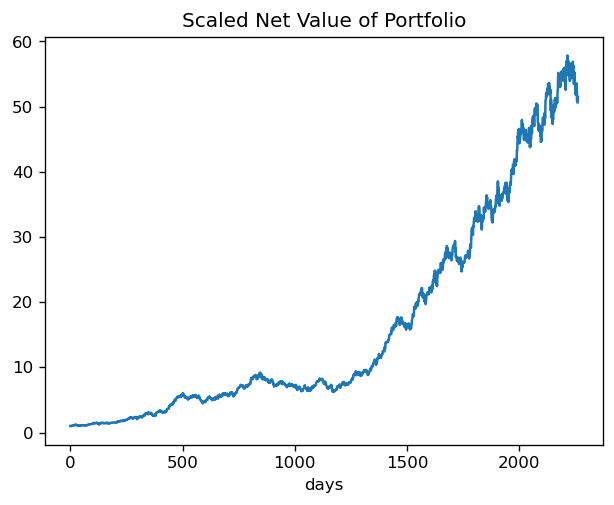

In [115]:
plt.figure(figsize=(6, 4.5), dpi=120)
plt.plot(brdf.net_value)
plt.title('Scaled Net Value of Portfolio')
plt.xlabel('days')

### Todo:
From current alpha generation (alpha ~ sum(coeffs x predictions)), we can perform OLS on testing data to optimize coeffs for alpha to the known next value.

Implement and test black litterman.

Perform a param search on remaining hyperparams, particularly ones involved in optimization such as lookback and var penalty.